# Evaluating LLM Driven Graph Creation
## The Plan
This notebook demonstrates my blog post on Evals for Graph Creation. We take Form 10K Annual Reports of various companies and convert them to Graph using Anthropic Claude.
1. Define Ontology
2. Ontology driven Entity & Relationship Extraction
3. SME feedback driven prompt iteration & Evaluation
4. Tracing & Clustering
5. Metrics
6. Integration with your existing Graph

## Prerequisites
If you intend to run this notebook, you need the following API keys. Please go to individual providers and get them.
- Anthropic Claude API Access (Running the notebook will cost you $0.5)
- Langsmith (Free Tier)


## Dependencies

First, lets install the dependencies.


In [ ]:
# Needed if you get Proxy error with Anthropic while running on Colab
!pip install -q --force-reinstall httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.7.0 which is incompatible.


In [ ]:
!pip install -qU instructor anthropic langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.9 requires langsmith<0.2.0,>=0.1.17, but you have langsmith 0.2.1 which is incompatible.
langchain-core 0.3.21 requires langsmith<0.2.0,>=0.1.125, but you have langsmith 0.2.1 which is incompatible.


In [3]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass('API key for Anthropic: ')
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('API key for Langsmith: ')
os.environ["LANGCHAIN_TRACING_V2"] = 'true'


API key for Anthropic: ··········
API key for Langsmith: ··········


## The Dataset
We will be using the Security and Exchange Commission's (SEC) Form 10K Annual reports of companies. More specifically, our focus will be Part I and that too the Business section of the form.

For people who are new to Form10K - this is the section that declares the following:
- Item 1: Business
  This section describes the company's core operations, including its products and services, revenue streams, and market positioning. It outlines how the company generates income and details its competitive landscape, including significant trends and challenges within the industry
- Item 1A: Risk Factors
  Here, the company identifies potential risks that could adversely affect its business, financial condition, or results. This includes market risks, operational challenges, regulatory changes, and any ongoing legal issues. Understanding these risks is essential for investors assessing the company's viability
- Item 1B: Unresolved Staff Comments
  This item addresses any significant comments from the SEC that have not been resolved from previous filings. It provides insight into any ongoing regulatory scrutiny or concerns raised by the SEC regarding the company's disclosures
- Item 2: Properties
  This section details the company's physical properties that are materially important to its operations, such as manufacturing facilities or real estate holdings
- Item 3: Legal Proceedings
  Companies must disclose significant legal proceedings they are involved in, including pending lawsuits that could impact their financial health or operations


Our dataset is extracted from [here](https://zenodo.org/records/13761154). Each file is a JSON as you see [here](https://raw.githubusercontent.com/ezhilvendhan/blogs/refs/heads/main/eval-graph-creation/data/000000217824000035.json) - containing the whole Form10K.

Since our focus is only Part I, let us write a few helper functions to extract only that portion. The function below helps to extract Part I section from multiple JSON files from our github [folder](https://raw.githubusercontent.com/ezhilvendhan/blogs/refs/heads/main/eval-graph-creation/data) and return them as a list of Part I text.

In [ ]:
import json
import requests

def extract_part1_content(data):
    """
    Extract and format content from PART I section recursively.

    Args:
        data (dict): Input dictionary containing document structure

    Returns:
        str: Formatted content from PART I section
    """
    def recursive_extract(content_obj, accumulated_text=""):
        """
        Recursively extract content from nested structure.

        Args:
            content_obj (dict): Content object to process
            accumulated_text (str): Accumulated text from previous recursions

        Returns:
            str: Combined formatted text
        """
        # Handle title and text if present
        txt = ''
        if content_obj.get('text'):
          txt = content_obj['text'].strip()

        if content_obj.get('title') :
            accumulated_text += f"Title: {content_obj['title']}\n  "
        if txt != '':
          accumulated_text += f"{txt}\n<!>\n"

        # Process nested content if present
        if content_obj.get('content'):
            if isinstance(content_obj['content'], list):
                for item in content_obj['content']:
                    accumulated_text += recursive_extract(item)
            elif isinstance(content_obj['content'], dict):
                accumulated_text += recursive_extract(content_obj['content'])

        return accumulated_text

    # Find PART I in the document
    try:
        document = data['document'][0]
        if 'content' in document:
            for section in document['content']:
                if section.get('title') == 'PART I':
                    return recursive_extract(section).strip('<!>\n')
        return "PART I section not found"
    except (KeyError, IndexError):
        return "Invalid document structure"

def fetch_form10k_part1():

    github_api_url = f"https://api.github.com/repos/ezhilvendhan/blogs/contents/eval-graph-creation/data"
    try:
        response = requests.get(github_api_url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        files = response.json()
        all_form10k_part1 = []
        for file in files:
            if file["type"] == "file" and file["name"].endswith(".json"):
                file_url = file["download_url"]
                file_response = requests.get(file_url)
                file_response.raise_for_status()
                try:
                    whole_form10k = json.loads(file_response.text)
                    part1 = extract_part1_content(whole_form10k)
                    all_form10k_part1.append(part1)
                except json.JSONDecodeError:
                    print(f"Warning: Skipping invalid JSON file: {file['name']}")

        return all_form10k_part1

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from GitHub: {e}")
        return []

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []

In [ ]:
all_form10k = fetch_form10k_part1()
len(all_form10k[1])

197803

## Define Ontology

Our dataset is unstructured and we are going to store them in our graph. We got multiple options to store:
- as per a domain specific schema (ontology)
- as hierarchical vector chunks
- mix of schema + text chunks

The choice depends on the kind of usecases you have. Storing as per Ontology can make the graph useful for many usecases - not just GraphRAG. It takes time and effort to define one, but you get control and good data governance advantages.

In this notebook, we will go with an Ontology driven extraction. Ideally you would be doing this exercise with your Subject Matter Expert to define the taxonomies.

This is our Ontology represented in Pydantic.

In [ ]:
from typing import List, Optional, Dict
from datetime import date
from pydantic import Field
from pydantic import BaseModel

class Business(BaseModel):
    """Item 1: Business description and operations"""
    id: str = Field(..., description="Unique identifier for the business section")
    description: str = Field(..., description="General description of the business")
    segments: List[str] = Field(default_factory=list, description="List of Business segments. Do no club segments together")
    products: List[str] = Field(default_factory=list, description="List of Main products and services")
    competition: str = Field(..., description="Competitive environment description")
    raw_materials: Optional[str] = Field(None, description="Description of raw materials used")
    intellectual_property: Optional[str] = Field(None, description="IP rights and portfolio")
    seasonality: Optional[str] = Field(None, description="Business seasonality patterns")
    employees: Optional[int] = Field(None, description="Number of employees")
    regulatory_environment: Optional[str] = Field(None, description="Regulatory framework description")

class RiskFactor(BaseModel):
    """Item 1A: Risk Factors"""
    id: str = Field(..., description="Unique identifier for the risk factor")
    risk_category: str = Field(..., description="Category of the risk")
    risk_description: str = Field(..., description="Detailed description of the risk")
    potential_impact: str = Field(..., description="Potential impact on business")
    mitigation_strategy: Optional[str] = Field(None, description="Risk mitigation strategy")

class Property(BaseModel):
    """Item 2: Properties"""
    id: str = Field(..., description="Unique identifier for the property")
    location: str = Field(..., description="Property location")
    property_type: str = Field(..., description="Type of property (Owned/Leased)")
    square_footage: Optional[float] = Field(None, description="Property size in square feet")
    primary_use: str = Field(..., description="Primary use of the property")
    expiration_date: Optional[date] = Field(None, description="Lease expiration date if applicable")

class LegalProceeding(BaseModel):
    """Item 3: Legal Proceedings"""
    id: str = Field(..., description="Unique identifier for the legal proceeding")
    case_description: str = Field(..., description="Description of the legal case")
    jurisdiction: str = Field(..., description="Legal jurisdiction")
    status: str = Field(..., description="Current status of the proceeding")
    potential_liability: Optional[float] = Field(None, description="Potential financial liability")
    expected_resolution: Optional[str] = Field(None, description="Expected resolution timeline")

class MineSafety(BaseModel):
    """Item 4: Mine Safety Disclosures"""
    id: str = Field(..., description="Unique identifier for mine safety record")
    violations: Optional[int] = Field(None, description="Number of safety violations")
    citations: List[str] = Field(default_factory=list, description="Safety citations received")
    assessments: Optional[float] = Field(None, description="Financial assessments or penalties")

class PartI(BaseModel):
    """Part I of Form 10-K"""
    id: str = Field(..., description="Unique identifier for Part I")
    business: Business = Field(..., description="Item 1: Business")
    risk_factors: List[RiskFactor] = Field(default_factory=list, description="Item 1A: Risk Factors")
    properties: List[Property] = Field(default_factory=list, description="Item 2: Properties")
    legal_proceedings: List[LegalProceeding] = Field(default_factory=list, description="Item 3: Legal Proceedings")
    mine_safety: Optional[MineSafety] = Field(None, description="Item 4: Mine Safety Disclosures")

class Form10K(BaseModel):
    """Form 10-K Document"""
    id: str = Field(..., description="Unique identifier for the Form 10-K")
    fiscal_year: int = Field(..., description="Fiscal year of the report")
    filing_date: date = Field(..., description="Date the form was filed")
    company_name: str = Field(..., description="Name of the company")
    cik: str = Field(..., description="Central Index Key (CIK) number")
    part_i: PartI = Field(..., description="Part I of Form 10-K")


## Ontology driven Entity & Relationship Extraction

We will now be using our Ontology to extract using the awesome [Instructor](https://python.useinstructor.com) library

In [ ]:
import instructor
from anthropic import Anthropic
from langsmith import wrappers, traceable

# Set up the client with prompt caching
client = instructor.from_anthropic(Anthropic())

def reduce(results: list):
    return {"output": "".join(str(results[0]))}

@traceable(run_type="llm")
def extract_form10k_part1(all_form10k):
  results = []
  for content in all_form10k[0:3]:
    resp, completion = client.chat.completions.create_with_completion(
          model="claude-3-5-haiku-20241022",
          messages=[
              {
                  "role": "user",
                  "content": [
                      {
                          "type": "text",
                          "text": "<Form10K-PART-1>" + content + "</Form10K-PART-1>"
                      },
                      {
                          "type": "text",
                          "text": "Extract Form 10K from the Part I text given above",
                      },
                  ],
              },
          ],
          response_model=Form10K,
          max_tokens=4000,
      )
    results.append((resp, completion, content))
  return results

results = extract_form10k_part1(all_form10k)

This is how our extraction looks like

In [ ]:
results[0][0]

Form10K(id='AE-2023-10K', fiscal_year=2023, filing_date=datetime.date(2024, 2, 29), company_name='Adams Resources & Energy, Inc.', cik='0000032945', part_i=PartI(id='PART-I-2023', business=Business(id='AE-BUSINESS-2023', description='Adams Resources & Energy, Inc. is a publicly traded Delaware corporation organized in 1973. Through its subsidiaries, the company is primarily engaged in crude oil marketing, truck and pipeline transportation of crude oil, terminalling and storage in various crude oil and natural gas basins in the lower 48 states of the United States. The company also conducts tank truck transportation of liquid chemicals, pressurized gases, asphalt and dry bulk, and recycles and repurposes off-specification fuels, lubricants, crude oil and other chemicals from producers in the U.S.', segments=['crude oil marketing, transportation and storage', 'tank truck transportation of liquid chemicals, pressurized gases, asphalt and dry bulk', 'pipeline transportation, terminalling a

## LLM As a Judge

All good with the extraction! For a Production ready system, this is not enough. We need to ensure that the data is extracted right and more importantly - no hallucinations!

Multiple options are there to evaluate the data like:
- Fine tuned custom models
- Use a God-level LLM as judge

Using LLM as a judge is a popular option but how can we ensure that the LLM evaluates it right. This is a great [paper](https://arxiv.org/abs/2404.12272) on that. We take a similar approach to evaluate our judge.

- Ask an LLM to evaluate & critique using a prompt and gather results
- Ask our Human SME to evaluate LLM's response
- Keep Iterating the prompt until we hit a reasonable alignment


I am going to focus only on the Part I - Business section for this evaluation

In [ ]:
results[0][2]

'Title: PART I\n  Title: Items 1 and 2. Business and Properties.\n  Title: General\n  Adams Resources & Energy, Inc. (“AE”) is a publicly traded Delaware corporation organized in 1973. Our common shares are listed on the NYSE American LLC (“NYSE American”) under the ticker symbol “AE”. Through our subsidiaries, we are primarily engaged in crude oil marketing, truck and pipeline transportation of crude oil, and terminalling and storage in various crude oil and natural gas basins in the lower 48 states of the United States (“U.S.”). In addition, we conduct tank truck transportation of liquid chemicals, pressurized gases, asphalt and dry bulk primarily in the lower 48 states of the U.S. with deliveries into Canada and Mexico, and with seventeen terminals across the U.S. We also recycle and repurpose off-specification fuels, lubricants, crude oil and other chemicals from producers in the U.S. Our headquarters are located in 22,197 square feet of office space located at 17 South Briar Hollo

This is our prompt structure to evaluate the Business section extraction. In your case, you may need to provide more examples so as to align the LLM with Human level evaluation.

We are going to ask the LLM to rate the extraction as PASS / FAIL. And also provide a critique on it. This will ensure we capture the rationale behind the result


In [ ]:
JUDGE_PROMPT_FOR_BUSINESS_SECTION = f"""You are a Named Entity & Relationships Extraction evaluator with advanced capabilities to judge if the extraction is good or not.
You understand the nuances of the Financial Industry - more specifically SEC's Form 10K and Neo4j Knowledge Graph, including what is likely to be most useful from a Graph perspective.

Here are some guidelines for evaluating queries:
- ensure that the extraction is accurate and do so only from the text provided
- For long text descriptions, try to summarize them and capture only what is necessary from a finance perspective

Example evaluations:

<examples>

<example-1>
<form10k>
ITEM 1. BUSINESS
Overview
GreenTech Solutions, Inc. ("GreenTech" or the "Company") is a leading provider of renewable energy technologies and sustainable infrastructure solutions. Founded in 1995, we design, manufacture, and install solar power systems, energy storage solutions, and smart grid technologies for residential, commercial, and utility-scale applications. Through continued innovation and strategic expansion, we have established ourselves as a trusted partner in the global transition to sustainable energy.
Business Operations and Segments
Our operations are structured to address the diverse needs of the renewable energy market. In the residential sector, we provide comprehensive solar solutions to homeowners through our Residential Solar Solutions division, which handles everything from initial energy assessment to system design, installation, and ongoing monitoring. Our Commercial & Industrial Systems division serves businesses, schools, and industrial facilities with larger-scale solar implementations and energy management solutions tailored to reduce operational costs and achieve sustainability goals. Through our Utility Infrastructure segment, we partner with power utilities to develop and maintain large-scale solar farms and energy storage facilities that feed directly into the power grid.
Products, Services and Technology
The backbone of our business consists of integrated solar and energy management solutions. We provide complete solar panel systems supported by our advanced installation methodologies. Our energy storage solutions incorporate cutting-edge battery technology to maximize energy efficiency. The Company's smart energy management software enables real-time monitoring and optimization of energy consumption. We also supply essential grid infrastructure components and provide comprehensive maintenance and monitoring services to ensure optimal system performance. Our technical support team offers 24/7 monitoring and rapid response services to maintain system efficiency and reliability.
Competition and Market Position
The renewable energy sector remains highly competitive, characterized by rapid technological advancement and evolving customer needs. We face competition from traditional energy companies that are expanding their renewable energy portfolios, pure-play solar providers, and international manufacturers. Key competitive factors in our market include technology efficiency, price, warranty terms, and installation quality. Major competitors include SunPower Corporation, Tesla, and First Solar, who generally have greater financial resources than us. Despite this competitive landscape, we maintain our market position through technological innovation, superior customer service, and comprehensive solution offerings.
Raw Materials and Supply Chain Management
The production and installation of our systems depend on various raw materials and components. Primary materials include silicon wafers, solar glass, aluminum frames, and lithium-ion battery components. We have established strategic relationships with multiple suppliers across Asia and North America to ensure supply chain resilience and maintain competitive pricing. Our diversified supplier base helps mitigate risks associated with supply chain disruptions and geopolitical uncertainties.
</form10k>

<query>
Form10K(part_i=PartI(
    id="GTECH_2023_PART1",
    business=Business(
        id="GTECH_2023_BUSINESS",
        description="GreenTech Solutions, Inc. ('GreenTech' or the 'Company') is a leading provider of renewable energy technologies and sustainable infrastructure solutions. Founded in 1995, we design, manufacture, and install solar power systems, energy storage solutions, and smart grid technologies for residential, commercial, and utility-scale applications. Through continued innovation and strategic expansion, we have established ourselves as a trusted partner in the global transition to sustainable energy.",
        segments=[
            "Residential Solar Solutions",
            "Commercial & Industrial Systems",
            "Utility Infrastructure"
        ],
        products=[
            "Solar panel systems",
            "Energy storage solutions",
            "Smart energy management software",
            "Grid infrastructure components",
            "Maintenance and monitoring services",
            "24/7 monitoring and rapid response services"
        ],
        competition="The renewable energy sector remains highly competitive, characterized by rapid technological advancement and evolving customer needs. We face competition from traditional energy companies that are expanding their renewable energy portfolios, pure-play solar providers, and international manufacturers. Key competitive factors in our market include technology efficiency, price, warranty terms, and installation quality. Major competitors include SunPower Corporation, Tesla, and First Solar, who generally have greater financial resources than us.",
        raw_materials="Primary materials include silicon wafers, solar glass, aluminum frames, and lithium-ion battery components. We have established strategic relationships with multiple suppliers across Asia and North America to ensure supply chain resilience and maintain competitive pricing. Our diversified supplier base helps mitigate risks associated with supply chain disruptions and geopolitical uncertainties.",
        intellectual_property=None,  # Not mentioned in the provided text
        seasonality=None,  # Not mentioned in the provided text
        employees=None,  # Not mentioned in the provided text
        regulatory_environment=None  # Not mentioned in the provided text
    )
))
</query>
<critique>
{{
  "critique": "Extraction is accurate. Unspecified sections are left out. However, description could have been shorter and simpler",
  "is_pass": "True"
}}
</critique>
</example-1>
"""

In [ ]:
class LLMEvalResults(BaseModel):
  is_pass: bool = Field(..., description="Is Business section extraction is accurate in the Form10K object? i.e `Business` content represented by Form10K.part_i.business")
  critique: str = Field(..., description="Reason why you think the Business section extraction is bad")


llm_evals = []
for resp, completion, text in results:
  eval_res, c = client.chat.completions.create_with_completion(
    model="claude-3-5-haiku-20241022",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "<form10k>" + text + "</form10k>"
                },
                {
                    "type": "text",
                    "text": JUDGE_PROMPT_FOR_BUSINESS_SECTION,
                },
            ],
        },
    ],
    response_model=LLMEvalResults,
    max_tokens=1000,
  )
  llm_evals.append((resp, eval_res, completion, text))

## SME feedback driven prompt iteration & Evaluation
Let us now capture these results as a CSV file and compare against that with a Human SME



In [ ]:
import csv

def print_and_save_results(results, filename="form10k_data.csv"):
    """Prints results with titles and saves them to a CSV file."""
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['id', 'company', 'content', 'llm_eval_critique', 'llm_eval_success', 'expert_critique', 'expert_success']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for resp, llm_eval, completion, text in results:
            print(f"File ID: {resp.cik}")
            try:
                s = ''
                s += f"Company Name: {resp.company_name}\n"
                s += f"Fiscal Year: {resp.fiscal_year}\n"
                s += f"Filing Date: {resp.filing_date}\n"

                # Business Section
                s = ''
                s += "Business:\n"
                s += f"  Description: {resp.part_i.business.description}\n"
                s += f"  Segments: {', '.join(resp.part_i.business.segments)}\n"
                s += f"  Products: {', '.join(resp.part_i.business.products)}\n"
                s += f"  Competition: {resp.part_i.business.competition}\n"

                if resp.part_i.business.raw_materials:
                    s += f"  Raw Materials: {resp.part_i.business.raw_materials}"
                if resp.part_i.business.intellectual_property:
                    s += f"  Intellectual Property: {resp.part_i.business.intellectual_property}"

                writer.writerow({'id': resp.cik, 'company': resp.company_name, 'content': s,
                                 'llm_eval_critique': llm_eval.critique,
                                 'llm_eval_success': llm_eval.is_pass,'expert_critique': '', 'expert_success': ''})

                # Risk Factors
                # s = ''
                # s += "\nRisk Factors:\n"
                # for risk in resp.part_i.risk_factors:
                #     s += f"  Risk Category: {risk.risk_category}\n"
                #     s += f"  Risk Description: {risk.risk_description}\n"
                #     s += f"  Potential Impact: {risk.potential_impact}\n"
                # writer.writerow({'id': resp.cik, 'company': resp.company_name, 'content': s})

            except AttributeError as e:
                print(f"Error processing data: {e}")
                print("Raw response:")
                print(resp)
                writer.writerow({'id': 'Error', 'company': 'Error', 'content': str(e), 'llm_eval_critique': '',
                                 'llm_eval_success': 'Error', 'expert_critique': '', 'expert_success': ''})



In [ ]:
print_and_save_results(llm_evals)

File ID: 0000032945
File ID: 2488
File ID: 0000004832


The next step is to gather Expert or Subject Matter Expert Feedback and fix the prompts accordingly until the LLM Evals align a certain threshold lets say, 80-90% with SME Evals.


Once aligned, the LLM as a Judge is ready to monitor and evaluate production pipeline extractions. Langsmith supports Auto-Evaluation and you can add the expert vetted prompt there to start evaluating the pipeline

## Tracing & Clustering
You can now use the tracing data from Langsmith and start analysing. For example - run clustering / data analysis and see which sorts of forms are used. Though we used only Form 10K here, your application might be using other forms as well. Clustering can be done using tools like [Lilac](https://docs.lilacml.com/blog/introducing-lilac.html)


Langsmith also provides an option to experiment various scenarios. Also, for continual in context learning, you can automatically configure to pick the most appropriate example from your tracing logs.


## Metrics

With Auto evals, you also would have collected a decent size of LLM evaluation results. Let's create some metrics to measure the performance.

Since this is a classification task, lets go with the following:

- Precision
- Recall
- ROC-AUC
- PR-AUC
- Separation of Distributions

I am going to go with some fictitious eval data to create these metrics.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def generate_evaluation_data(n_samples=500):
    """
    Generate synthetic evaluation data with realistic prediction errors
    """
    np.random.seed(42)

    data = []
    field_types = ['description', 'competition', 'segments', 'products', 'raw_materials']

    # Different success rates for different field types
    field_success_rates = {
        'description': 0.85,
        'competition': 0.75,
        'segments': 0.80,
        'products': 0.78,
        'raw_materials': 0.70
    }

    for i in range(n_samples):
        field_type = np.random.choice(field_types)
        success_rate = field_success_rates[field_type]

        # True label (ground truth)
        true_label = np.random.choice(['PASS', 'FAIL'], p=[0.7, 0.3])

        # Predicted label (with some errors)
        if true_label == 'PASS':
            # Model sometimes fails to detect actual passes
            predicted = np.random.choice(['PASS', 'FAIL'], p=[success_rate, 1-success_rate])
        else:
            # Model sometimes incorrectly predicts passes
            predicted = np.random.choice(['PASS', 'FAIL'], p=[1-success_rate, success_rate])

        data.append({
            'extraction_id': f'EXTR_{i:03d}',
            'document_id': f'DOC_{i//5:03d}',
            'field_type': field_type,
            'true_label': true_label,
            'predicted': predicted,
            'confidence_score': np.random.beta(5, 2) if predicted == 'PASS' else np.random.beta(2, 5)
        })

    df = pd.DataFrame(data)
    df.to_csv('ner_evaluation_results.csv', index=False)
    print("Evaluation data saved to ner_evaluation_results.csv")
    return df

In [ ]:
# Generate synthetic data
print("Generating synthetic evaluation data...")
df = generate_evaluation_data(500)

Generating synthetic evaluation data...
Evaluation data saved to ner_evaluation_results.csv


In [ ]:
def analyze_evaluation_results(csv_file='ner_evaluation_results.csv'):
    """
    Analyze evaluation results from CSV, comparing true labels with predictions
    """
    # Read CSV file
    df = pd.read_csv(csv_file)

    # Overall statistics
    total_evaluations = len(df)
    true_pass_rate = (df['true_label'] == 'PASS').mean()
    predicted_pass_rate = (df['predicted'] == 'PASS').mean()
    accuracy = (df['true_label'] == df['predicted']).mean()

    print("\nOverall Evaluation Results:")
    print(f"Total Evaluations: {total_evaluations}")
    print(f"True Pass Rate: {true_pass_rate:.2%}")
    print(f"Predicted Pass Rate: {predicted_pass_rate:.2%}")
    print(f"Overall Accuracy: {accuracy:.2%}")

    # Field-type specific statistics
    print("\nResults by Field Type:")
    field_stats = pd.DataFrame({
        'Total': df.groupby('field_type').size(),
        'True_Pass_Rate': df.groupby('field_type').apply(lambda x: (x['true_label'] == 'PASS').mean()),
        'Predicted_Pass_Rate': df.groupby('field_type').apply(lambda x: (x['predicted'] == 'PASS').mean()),
        'Accuracy': df.groupby('field_type').apply(lambda x: (x['true_label'] == x['predicted']).mean())
    })
    print(field_stats.round(4))

    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. True vs Predicted Distribution
    true_pred_counts = pd.DataFrame({
        'True': df['true_label'].value_counts(),
        'Predicted': df['predicted'].value_counts()
    })
    true_pred_counts.plot(kind='bar', ax=ax1)
    ax1.set_title('True vs Predicted Label Distribution')
    ax1.set_ylabel('Count')

    # 2. Accuracy by Field Type
    field_stats['Accuracy'].sort_values(ascending=True).plot(kind='barh', ax=ax2)
    ax2.set_title('Accuracy by Field Type')
    ax2.set_xlabel('Accuracy')

    # 3. Confusion Matrix by Field Type
    confusion_by_field = pd.crosstab([df['field_type'], df['true_label']], df['predicted'])
    confusion_by_field.unstack().plot(kind='bar', ax=ax3)
    ax3.set_title('Confusion Matrix by Field Type')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

    # 4. Confidence Score Distribution
    sns.boxplot(data=df, x='field_type', y='confidence_score', hue='true_label', ax=ax4)
    ax4.set_title('Confidence Score Distribution by Field Type')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Additional Analysis: Document-level statistics
    print("\nDocument-level Statistics:")
    doc_stats = pd.DataFrame({
        'Total_Extractions': df.groupby('document_id').size(),
        'True_Pass_Rate': df.groupby('document_id').apply(lambda x: (x['true_label'] == 'PASS').mean()),
        'Predicted_Pass_Rate': df.groupby('document_id').apply(lambda x: (x['predicted'] == 'PASS').mean()),
        'Accuracy': df.groupby('document_id').apply(lambda x: (x['true_label'] == x['predicted']).mean())
    })

    print("\nDocument Performance Summary:")
    print(f"Documents with >90% accuracy: {(doc_stats['Accuracy'] > 0.9).sum()}")
    print(f"Documents with <50% accuracy: {(doc_stats['Accuracy'] < 0.5).sum()}")

    # Error Analysis
    print("\nError Analysis:")
    error_mask = df['true_label'] != df['predicted']
    error_by_field = df[error_mask].groupby('field_type').size()
    error_rate_by_field = error_by_field / df.groupby('field_type').size()
    print("\nError Rate by Field Type:")
    print(error_rate_by_field.round(4))

    # High Confidence Errors
    high_conf_errors = df[
        (error_mask) &
        (df['confidence_score'] > df['confidence_score'].median())
    ]
    print(f"\nHigh Confidence Errors: {len(high_conf_errors)} ({len(high_conf_errors)/len(df):.2%} of total)")

    return df, field_stats, doc_stats


Analyzing evaluation results...

Overall Evaluation Results:
Total Evaluations: 500
True Pass Rate: 64.80%
Predicted Pass Rate: 55.00%
Overall Accuracy: 77.40%

Results by Field Type:
               Total  True_Pass_Rate  Predicted_Pass_Rate  Accuracy
field_type                                                         
competition       96          0.6354               0.5729    0.7708
description      112          0.7500               0.6518    0.8482
products          98          0.6224               0.5204    0.7755
raw_materials     97          0.6495               0.5361    0.6598
segments          97          0.5670               0.4536    0.8041


<ipython-input-21-9364316a4afa>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'True_Pass_Rate': df.groupby('field_type').apply(lambda x: (x['true_label'] == 'PASS').mean()),
<ipython-input-21-9364316a4afa>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Predicted_Pass_Rate': df.groupby('field_type').apply(lambda x: (x['predicted'] == 'PASS').mean()),
<ipython-input-21-9364316a4afa>:26: DeprecationWar

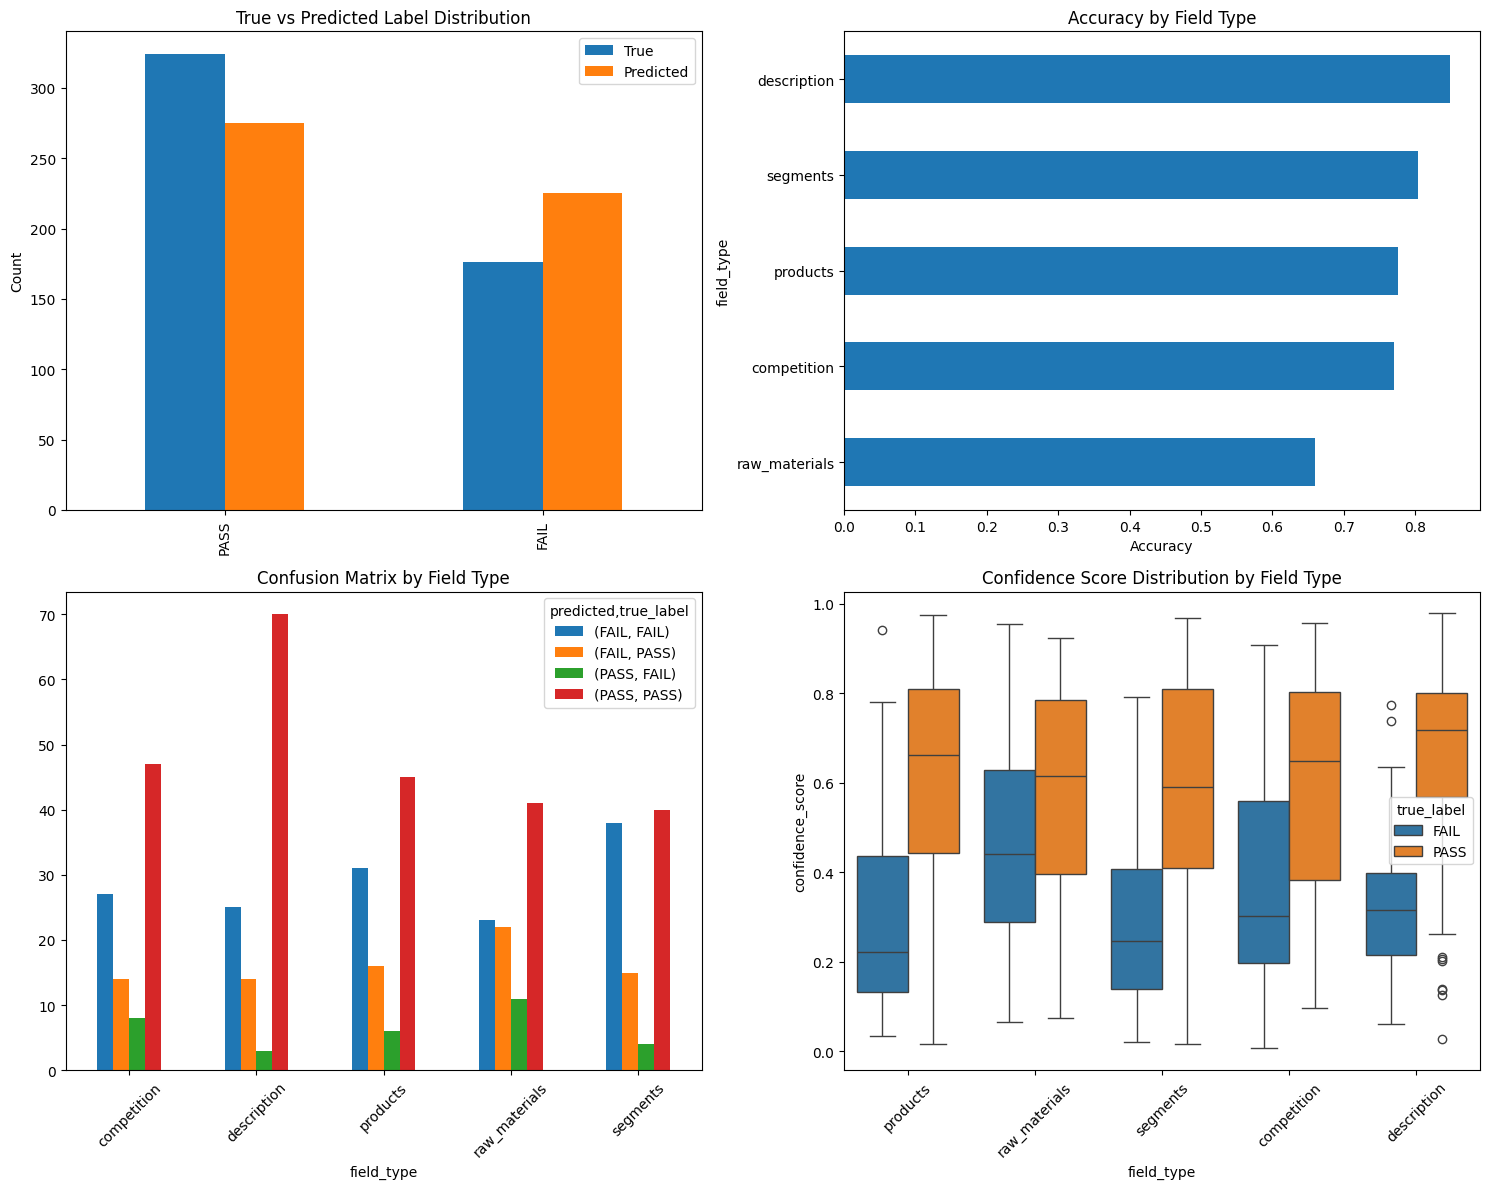


Document-level Statistics:

Document Performance Summary:
Documents with >90% accuracy: 27
Documents with <50% accuracy: 10

Error Analysis:

Error Rate by Field Type:
field_type
competition      0.2292
description      0.1518
products         0.2245
raw_materials    0.3402
segments         0.1959
dtype: float64

High Confidence Errors: 33 (6.60% of total)


<ipython-input-21-9364316a4afa>:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'True_Pass_Rate': df.groupby('document_id').apply(lambda x: (x['true_label'] == 'PASS').mean()),
<ipython-input-21-9364316a4afa>:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Predicted_Pass_Rate': df.groupby('document_id').apply(lambda x: (x['predicted'] == 'PASS').mean()),
<ipython-input-21-9364316a4afa>:67: DeprecationW

In [ ]:
# Analyze results
print("\nAnalyzing evaluation results...")
df, field_stats, doc_stats = analyze_evaluation_results()

Lets calculate the metrics now

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, roc_curve, precision_recall_curve, auc
from scipy import stats

def calculate_core_metrics(df):
    """
    Calculate core metrics comparing true labels with predictions
    """
    # Convert true labels and predictions to 1/0
    y_true = (df['true_label'] == 'PASS').astype(int)
    y_pred = (df['predicted'] == 'PASS').astype(int)
    y_score = df['confidence_score']  # Using model's confidence scores

    # Calculate precision and recall using actual predictions
    metrics = {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
    }

    # Calculate ROC curve and AUC using confidence scores
    fpr, tpr, _ = roc_curve(y_true, y_score)
    metrics['roc_auc'] = auc(fpr, tpr)

    # Calculate PR curve and AUC using confidence scores
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_score)
    metrics['pr_auc'] = auc(recall_curve, precision_curve)

    return metrics, fpr, tpr, precision_curve, recall_curve, y_true, y_score

def plot_core_metrics(df, metrics, fpr, tpr, precision, recall, y_true, y_score):
    """
    Create visualizations for core metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. ROC Curve
    axes[0, 0].plot(fpr, tpr, label=f'ROC curve (AUC = {metrics["roc_auc"]:.2f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--')  # diagonal line
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend(loc='lower right')

    # 2. Precision-Recall Curve
    axes[0, 1].plot(recall, precision, label=f'PR curve (AUC = {metrics["pr_auc"]:.2f})')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend(loc='lower left')

    # 3. Confidence Score Distribution Separation
    pass_scores = y_score[y_true == 1]
    fail_scores = y_score[y_true == 0]

    # Calculate KS statistic for distribution separation
    ks_stat, p_value = stats.ks_2samp(pass_scores, fail_scores)

    sns.kdeplot(data=pass_scores, ax=axes[1, 0], label='True PASS', color='green')
    sns.kdeplot(data=fail_scores, ax=axes[1, 0], label='True FAIL', color='red')
    axes[1, 0].set_title(f'Confidence Score Distributions (KS stat = {ks_stat:.2f})')
    axes[1, 0].set_xlabel('Confidence Score')
    axes[1, 0].legend()

    # 4. Metrics Summary
    axes[1, 1].axis('off')
    metrics_text = (
        f"Core Metrics Summary:\n\n"
        f"Precision: {metrics['precision']:.3f}\n"
        f"Recall: {metrics['recall']:.3f}\n"
        f"ROC-AUC: {metrics['roc_auc']:.3f}\n"
        f"PR-AUC: {metrics['pr_auc']:.3f}\n"
        f"Distribution Separation (KS): {ks_stat:.3f}\n"
        f"KS p-value: {p_value:.3e}"
    )
    axes[1, 1].text(0.1, 0.7, metrics_text, fontsize=12, family='monospace')

    plt.tight_layout()
    return fig

def analyze_core_metrics(csv_file='ner_evaluation_results.csv'):
    """
    Analyze core metrics from evaluation results
    """
    # Read CSV file
    df = pd.read_csv(csv_file)

    # Calculate metrics
    metrics, fpr, tpr, precision, recall, y_true, y_score = calculate_core_metrics(df)

    # Plot metrics
    fig = plot_core_metrics(df, metrics, fpr, tpr, precision, recall, y_true, y_score)

    # Print metrics summary
    print("\nCore Metrics Summary:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Additional field-type specific metrics
    print("\nMetrics by Field Type:")
    for field in df['field_type'].unique():
        field_df = df[df['field_type'] == field]
        field_true = (field_df['true_label'] == 'PASS').astype(int)
        field_pred = (field_df['predicted'] == 'PASS').astype(int)

        print(f"\n{field}:")
        print(f"Precision: {precision_score(field_true, field_pred):.4f}")
        print(f"Recall: {recall_score(field_true, field_pred):.4f}")

    return metrics


Core Metrics Summary:
precision: 0.8836
recall: 0.7500
roc_auc: 0.7679
pr_auc: 0.8408

Metrics by Field Type:

products:
Precision: 0.8824
Recall: 0.7377

raw_materials:
Precision: 0.7885
Recall: 0.6508

segments:
Precision: 0.9091
Recall: 0.7273

competition:
Precision: 0.8545
Recall: 0.7705

description:
Precision: 0.9589
Recall: 0.8333


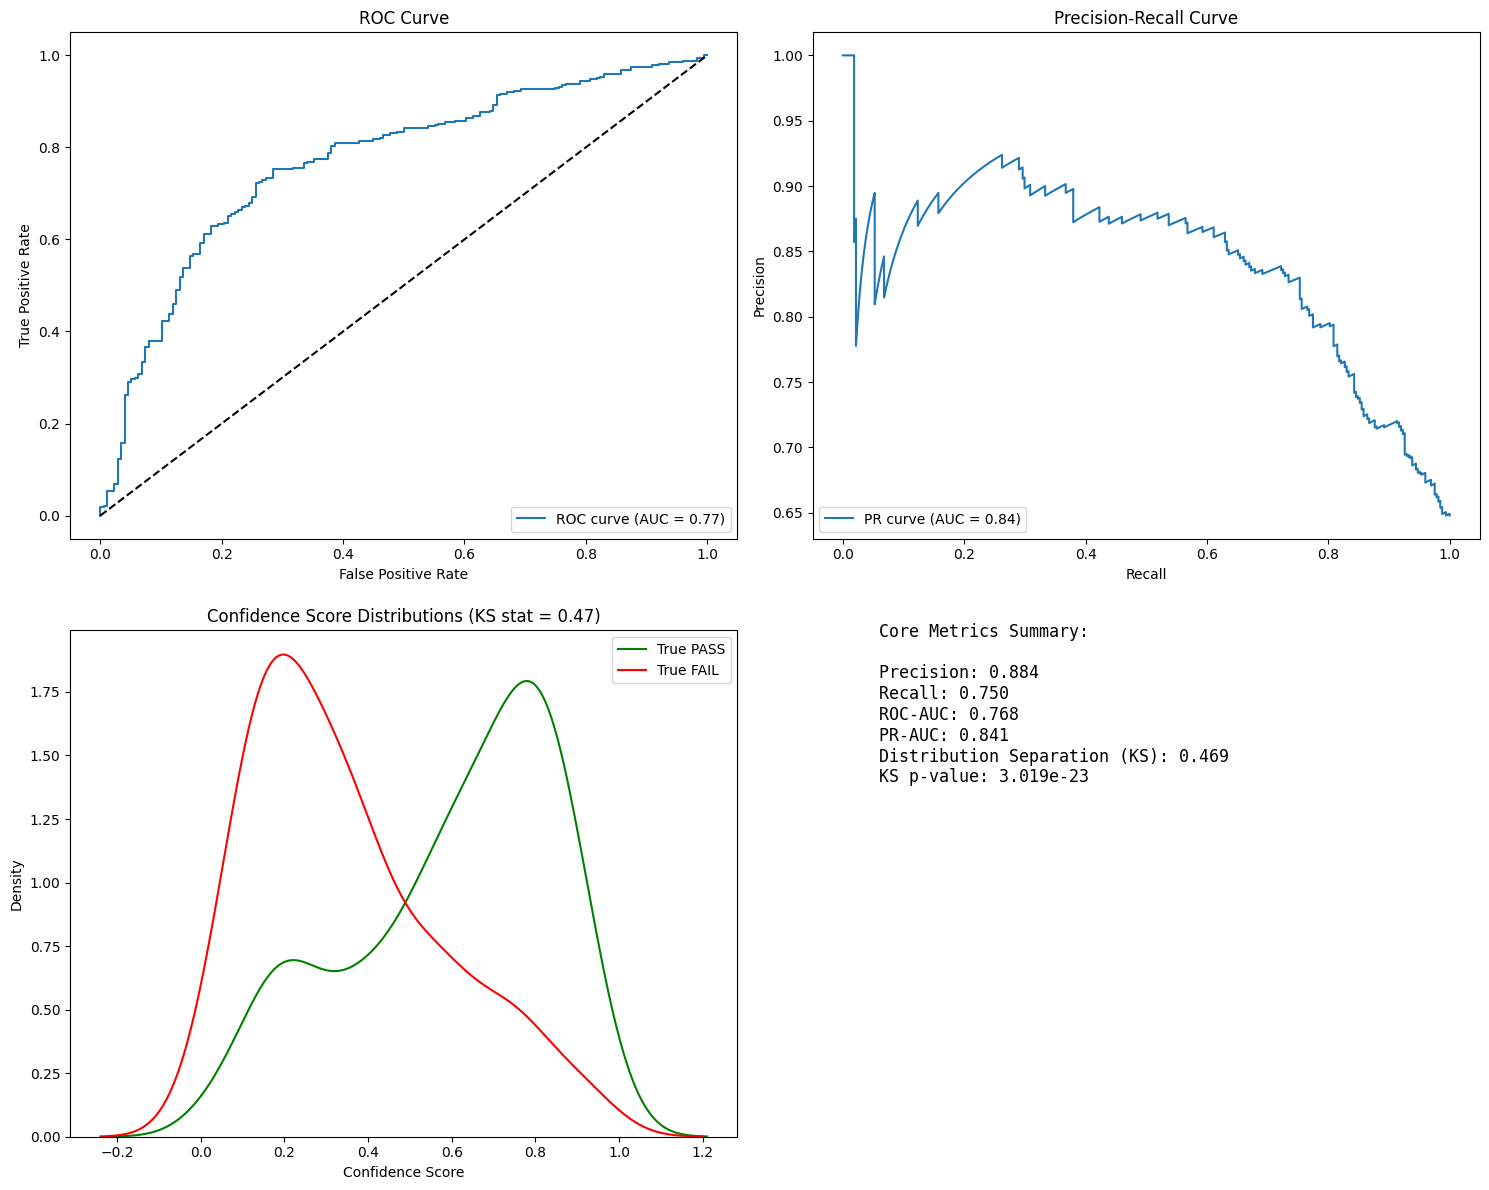

In [ ]:
metrics = analyze_core_metrics()

## Integration with your existing Graph

---



With Evals in place for extraction, we can move on to integrate with your existing graph. Here you might need to do some entity resolution and deduplication of nodes so that you can safely merge them.

Roughly, you can consider the following checks as part of your pipeline:
- Duplicate node checks & relationship validation
- Schema conformity
- Versioning & Provenance
- Rollback capability
- Performance evaluation